# HSE 2021: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format) 

$$L(w, w_0) = \frac{1}{N} \sum_i^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$

$$\nabla_{w}L(w, w_0) = {1 \over N} \sum_i^N ({{1} \over {1 + exp(-y_i(w^\top x_i+w_0))}} \cdot{} exp(-y_i(w^\top x_i + w_0)) \cdot{} (-y_i x_i)) + \gamma sgn(w) + 2\beta w$$

$$\nabla_{w_0}L(w, w_0) = {1 \over N} \sum_i^N {{1} \over {1 + exp(-y_i(w^\top x_i+w_0))}} \cdot{} exp(-y_i(w^\top x_i + w_0)) \cdot{} (-y_i)$$

#### 2. [0.5 points] Implement the Elastic Net loss (as a function)

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    N = len(y)
    loss = 0
    for i in range(N):
        loss += np.log(1 + np.exp(-y[i] * (np.dot(X[i], w.T) + w0)))
    loss /= N
    loss += gamma * np.sum(np.abs(w)) + beta * np.dot(w, w.T)[0][0]
    
    return loss[0]

#### 3. [0.5 points] Implement the gradient (as a function)

In [3]:
def get_grad(X, y, w, w0, gamma=1., beta=1.):
    '''
    w is a row (1, N)
    X (N, n_features)
    y (N)
    grad_w (1, N)
    '''
    N = len(y)
    
    grad_w0 = 0
    grad_w = 0
    
    wnew = np.atleast_2d(w)
    
    for i in range(N):
        common_part = 1 / (1 + np.exp(- y[i] * (np.dot(wnew, X[i].T) + w0))) * np.exp(- y[i] * (np.dot(wnew, X[i].T) + w0))
        grad_w += common_part[0] * (- y[i] * np.atleast_2d(X[i]))
        grad_w0 += common_part[0] * (- y[i])
    
    grad_w /= N
    grad_w0 /= N
    
    grad_w += gamma * np.sign(wnew) + beta * 2 * wnew
    
    return grad_w, grad_w0

#### Check yourself

In [5]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
print(grad_w, grad_w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844, 
                   rtol=1e-2)
)

[[-2.73262181 -1.87176392  1.30051023  2.53598816 -2.71198278]] -0.20782319347690742


####  4. [1 point]  Implement gradient descent and plot the decision boundary of the result

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [6]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, tolerance=0.01, max_iter=1000, random_state=42, lr=1e-3):  
        self.beta = beta        
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.random_state = random_state
        self.lr = lr
        self.loss_history = []
        
    def fit(self, X, y):
        # init weights randomly
        self.w = np.atleast_2d(np.random.randn(X.shape[1]) * 0.0001)
        self.w0 = np.random.randn(1)[0] * 0.0001 
        
        dW = 0
        dW0 = 0
        for _ in range(self.max_iter):
            dW, dW0 = get_grad(X, y, self.w, self.w0, self.gamma, self.beta)
            self.w -= dW * self.lr
            self.w0 -= dW0 * self.lr
            
            if (self.euclidian_norm(dW) < self.tolerance):
                return self
            
            self.loss_history.append(self.calc_loss(X, y))
        
        return self
    
    def predict(self, X):
        predict_proba = self.predict_proba(X).T
        predict = []
        for i in range(predict_proba.shape[1]): 
            predict.append(-1 if predict_proba[0][i] > predict_proba[1][i] else 1)
        return np.array(predict)
        
    def calc_loss(self, X, y):
        return loss(X, y, self.w, self.w0, self.gamma, self.beta)
    
    def predict_proba(self, X):
        return np.array([1 / (1 + np.exp(np.dot(X, self.w.T) + self.w0)), 1 / (1 + np.exp(-np.dot(X, self.w.T) - self.w0))])[:,:,0].T
    
    def euclidian_norm(self, a):
        return np.sqrt(np.dot(a, a.T))

In [7]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [8]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)
    
    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

In [9]:
model = Logit(0.01, 0.05)
y[y == 0] = -1
model.fit(X, y)


Logit(beta=0.01, gamma=0.05, lr=0.001, max_iter=1000, random_state=42,
      tolerance=0.01)

In [11]:
print(X.shape, y.shape)

(180, 2) (180,)


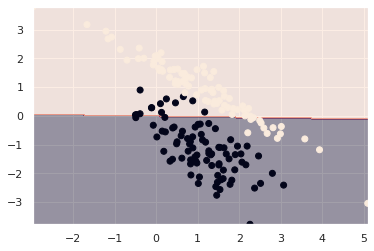

In [10]:
plot_decision_boundary(model, X, y)

#### 5. [0.5 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

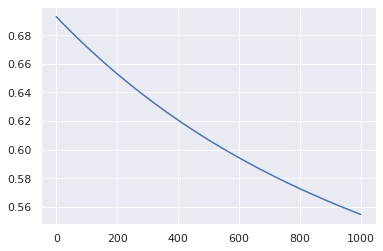

In [11]:
sns.lineplot(x=np.linspace(0, 1000, 1000), y=model.loss_history)
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

def model_quality(y, y_pred):
    return accuracy_score(y, y_pred), roc_auc_score(y, y_pred), f1_score(y, y_pred)

In [13]:
print('Accuracy, ROC-AUC, F1')
print(model_quality(y, model.predict(X)))

Accuracy, ROC-AUC, F1
(0.85, 0.8500000000000001, 0.8491620111731844)


## PART 2: Support Vector Machines

#### 6. [1 point] Using the same dataset, train SVM Classifier from Sklearn. Try different kernels, regularization coefficients and show how they affect accuracy, roc_auc and f1 score. Make plots for the dependences between metrics and parameters. Make conclusions.

In [51]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [15]:
svm_quality = pd.DataFrame(columns=['accuracy', 'roc-auc', 'f1'])
regs = np.logspace(-3, 0, 5)

In [16]:
def plot_scores(quality):
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
    sns.barplot(x=quality['accuracy'], y=quality.index, ax=axs[0])
    sns.barplot(x=quality['roc-auc'], y=quality.index, ax=axs[1])
    sns.barplot(x=quality['f1'], y=quality.index, ax=axs[2])
    axs[0].set_title('Accuracy')
    axs[1].set_title('ROC-AUC')
    axs[2].set_title('F1')
    plt.show()

In [17]:
#linear
for r in regs:
    model = svm.SVC(C=r, kernel='linear')
    model.fit(X_train, y_train)
    svm_quality.loc['linear C={:.4f}'.format(r)] = model_quality(y_test, model.predict(X_test))

In [18]:
# polynomial with deg=2,3,4

for r in regs:
    model = svm.SVC(C=r, kernel='poly', degree=2)
    model.fit(X_train, y_train)
    svm_quality.loc['poly deg=2 C={:.4f}'.format(r)] = model_quality(y_test, model.predict(X_test))

for r in regs:
    model = svm.SVC(C=r, kernel='poly', degree=3)
    model.fit(X_train, y_train)
    svm_quality.loc['poly deg=3 C={:.4f}'.format(r)] = model_quality(y_test, model.predict(X_test))
    
for r in regs:
    model = svm.SVC(C=r, kernel='poly', degree=4)
    model.fit(X_train, y_train)
    svm_quality.loc['poly deg=4 C={:.4f}'.format(r)] = model_quality(y_test, model.predict(X_test))

In [19]:
for r in regs:
    model = svm.SVC(C=r, kernel='rbf')
    model.fit(X_train, y_train)
    svm_quality.loc['rbf C={:.4f}'.format(r)] = model_quality(y_test, model.predict(X_test))

In [20]:
for r in regs:
    model = svm.SVC(C=r, kernel='sigmoid')
    model.fit(X_train, y_train)
    svm_quality.loc['sigmoid C={:.4f}'.format(r)] = model_quality(y_test, model.predict(X_test))

In [21]:
svm_quality

,accuracy,roc-auc,f1
linear C=0.0010,0.472222,0.500000,0.000000
linear C=0.0056,0.888889,0.885449,0.900000
linear C=0.0316,0.944444,0.941176,0.950000
linear C=0.1778,0.972222,0.970588,0.974359
linear C=1.0000,0.972222,0.970588,0.974359
poly deg=2 C=0.0010,0.472222,0.500000,0.000000
poly deg=2 C=0.0056,0.472222,0.500000,0.000000
poly deg=2 C=0.0316,0.694444,0.685759,0.744186
poly deg=2 C=0.1778,1.000000,1.000000,1.000000
poly deg=2 C=1.0000,1.000000,1.000000,1.000000


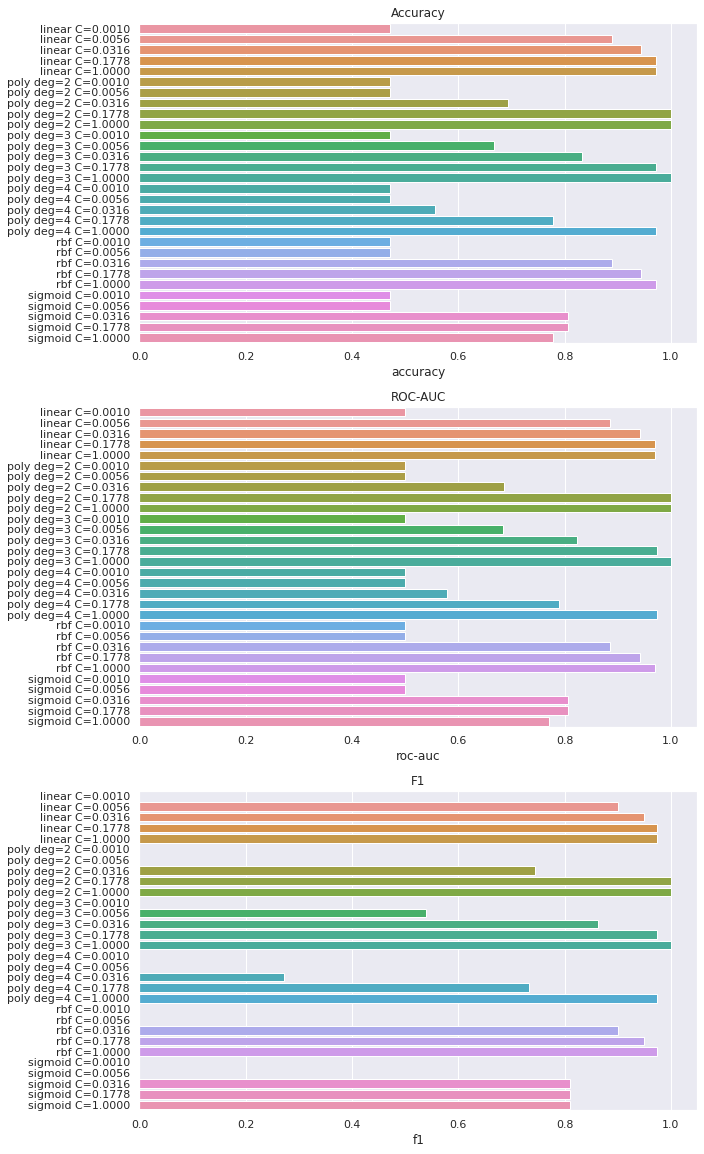

In [22]:
plot_scores(svm_quality)

**Conclusions**
1. As we can see from graphics the best classifications were polynomial with degree 2 and 3, regularization coefficient 1.0.

2. Low regularization coefficient - bad results, best in each kernel - 1.0

## PART 3: Natural Language Processing

#### 7. [2 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors: 
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 100
    * fix random state and randomly choose sentences in the folowing proportion "30k : 15k : 7k : 20k: 40k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center> 
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr> 
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td> 
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td> 
        <tr><td> ... </td><td> ... </td><td> 
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset 
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and lemmatize the words
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

I did this homework in Google Colab, so had to mount gdrive to access data

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Function for reading file and dividing into sentences

In [15]:
import re
import os

def read_textfile(filename, author_name):
    file_data = pd.DataFrame(columns=['sentence', 'author'])
    with open(filename) as file:
        text = file.read()
    sents = re.split(r' *[\.\?!\n][\'"\)\]]* *', text)
    for sentence in sents:
        if len(sentence) >= 15:
            file_data = file_data.append({'sentence' : sentence, 'author' : author_name}, ignore_index=True)
    return file_data

I picked the following authors: Достоевский, Толстой, Гоголь, Герцен, Пушкин, Лермонтов

Collecting data... Works in about 10 min


In [16]:
prose = pd.DataFrame(columns = ['sentence', 'author'])
base_path = '/content/drive/MyDrive/Colab Notebooks/nlp/data/'

for filename in os.listdir(base_path + 'Dostoevsky'):
    if (re.match('.*\.txt', filename)):
        prose = prose.append(read_textfile(base_path + 'Dostoevsky/' + filename, 'Достоевский'), ignore_index=True)

for filename in os.listdir(base_path + 'Gogol'):
    if (re.match('.*\.txt', filename)):
        prose = prose.append(read_textfile(base_path + 'Gogol/' + filename, 'Гоголь'), ignore_index=True)
    
for filename in os.listdir(base_path + 'Herzen'):
    if (re.match('.*\.txt', filename)):
        prose = prose.append(read_textfile(base_path + 'Herzen/' + filename, 'Герцен'), ignore_index=True)
    
for filename in os.listdir(base_path + 'Lermontov'):
    if (re.match('.*\.txt', filename)):
        prose = prose.append(read_textfile(base_path + 'Lermontov/' + filename, 'Лермонтов'), ignore_index=True)
    
for filename in os.listdir(base_path + 'Pushkin'):
    if (re.match('.*\.txt', filename)):
        prose = prose.append(read_textfile(base_path + 'Pushkin/' + filename, 'Пушкин'), ignore_index=True)
    
for filename in os.listdir(base_path + 'Tolstoy'):
    if (re.match('.*\.txt', filename)):
        prose = prose.append(read_textfile(base_path + 'Tolstoy/' + filename, 'Толстой'), ignore_index=True)
    


In [17]:
prose['author'].value_counts()

Достоевский    129443
Толстой         98708
Гоголь          24712
Герцен          18845
Пушкин          10901
Лермонтов        5557
Name: author, dtype: int64

In [18]:
prose.head()

,sentence,author
0,Федор Михайлович Достоевский,Достоевский
1,Ох уж эти мне сказочники,Достоевский
2,"Нет чтобы написать что-нибудь полезное,",Достоевский
3,"приятное, усладительное,",Достоевский
4,а то всю подноготную в земле вырывают,Достоевский


I made two datasets: full and small for testing models

In [19]:
proportion = [40000, 30000, 20000, 15000, 7000, 3000]
authors =      {'Достоевский' : 40000, 'Толстой' : 30000, 'Гоголь' : 20000, 'Герцен' : 15000, 'Пушкин' : 7000, 'Лермонтов' : 3000}
# for testing models on small dataset
authors_test = {'Достоевский' : 400, 'Толстой' : 300, 'Гоголь' : 200, 'Герцен' : 150, 'Пушкин' : 70, 'Лермонтов' : 30}

prose_sampled = pd.DataFrame(columns = ['sentence', 'author'])
for author in authors.keys():
  prose_sampled = prose_sampled.append(prose[prose['author'] == author].sample(n=authors.get(author)))

# test
prose_test = pd.DataFrame(columns = ['sentence', 'author'])
for author in authors_test.keys():
  prose_test = prose_test.append(prose[prose['author'] == author].sample(n=authors_test.get(author)))

In [20]:
prose_sampled['author'].value_counts()

Достоевский    40000
Толстой        30000
Гоголь         20000
Герцен         15000
Пушкин          7000
Лермонтов       3000
Name: author, dtype: int64

In [21]:
import string
import nltk

nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

word_tokenizer = nltk.WordPunctTokenizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Drop stop words, punctiation, numbers

In [22]:
def clear_data(data):
  sentences = []
  for sentence in data['sentence']:
    sentence_lower = sentence.lower() 
    tokens = word_tokenizer.tokenize(sentence_lower) 
    
    tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and not word.isdigit() and word not in '–,«»,')]
    
    sentences.append(tokens) 
  
  return sentences


In [23]:
sentences = clear_data(prose_sampled)
sentences_test = clear_data(prose_test)

In [24]:
target = prose_sampled['author'].values
target[:5]

array(['Достоевский', 'Достоевский', 'Достоевский', 'Достоевский',
       'Достоевский'], dtype=object)

In [25]:
target_test = prose_test['author'].values

In [26]:
!pip install pymorphy2

     |████████████████████████████████| 61kB 3.2MB/s 
     |████████████████████████████████| 8.2MB 5.4MB/s 


In [27]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

Lemmantization works better on russian texts

In [28]:
sentences_lemmantized = []
for i in range(len(sentences)):
  temp = [morph.parse(word)[0].normal_form for word in sentences[i]]
  sentences_lemmantized.append(' '.join(temp))

In [29]:
sentences_lemmantized_test = []
for i in range(len(sentences_test)):
  temp = [morph.parse(word)[0].normal_form for word in sentences_test[i]]
  sentences_lemmantized_test.append(' '.join(temp))

In [30]:
sentences_lemmantized[:3]

['давеча действительно дело настолечко солгать',
 'дело оно брат такой медовый речь точить таки обидно',
 'упоминать время немой тяжело']

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
n_features = 70
vectorizer = CountVectorizer(max_features=n_features)
vectorizer.fit(sentences_lemmantized)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=70, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [32]:
X_bow = vectorizer.transform(sentences_lemmantized)

In [40]:
print(X_bow[:3])

  (2, 11)	1
  (2, 68)	1


In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer

vectorizer_tfidf = TfidfVectorizer(max_features=n_features) 
vectorizer_tfidf.fit(sentences_lemmantized)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=70,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [34]:
X_tfidf = vectorizer_tfidf.transform(sentences_lemmantized)

In [37]:
print(X_tfidf[:3])

  (0, 19)	0.7099065328502963
  (0, 15)	0.7042958999003693
  (1, 68)	0.41361393921129014
  (1, 28)	0.6620664434952866
  (1, 0)	0.6249732263766355
  (2, 63)	1.0


In [35]:
vectorizer_tfidf_test = TfidfVectorizer(max_features=n_features) 
vectorizer_tfidf_test.fit(sentences_lemmantized_test)
X_tfidf_test = vectorizer_tfidf_test.transform(sentences_lemmantized_test)

For further tasks I chose TF-IDF model because it contains more information than just count of most important words, like BoW. It holds information about how frequent the word is and it performs better (according to ML articles)

###  Binary classification

#### 8. [2 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn) 

##### 1. 
* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 3/4 split rate (don't forget to fix the random state)
* train the models using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn) 
* make conclusions about the performance of your models

##### 2. 
* using GridSearchCV - find the best parameters for the models (by ROC_AUC score)
* make several plots to address the dependence between ROC_AUC score and parameters
* make conclusions about the models

In [36]:
from sklearn.model_selection import train_test_split

author_class = {'Достоевский' : 0, 'Толстой' : 1, 'Гоголь' : 2, 'Герцен' : 3, 'Пушкин' : 4, 'Лермонтов' : 5}
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, 
                                                                    [author_class.get(author) for author in target],
                                                                    random_state=42,
                                                                    train_size=0.75)

X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, 
                                                                    [author_class.get(author) for author in target],
                                                                    random_state=42,
                                                                    train_size=0.75)

In [53]:
two_authors = [2, 3] # 'Гоголь', 'Герцен'
print('Class proportion: {0} for Гоголь, {1} for Герцен in train dataset'.format((y_train_tfidf.count(2)), 
                                        (y_train_tfidf.count(3))))

arr = np.array(y_train_tfidf)
indexes_train = ((arr == 2) | (arr == 3)).nonzero()[0]
arr = np.array(y_test_tfidf)
indexes_test = ((arr == 2) | (arr == 3)).nonzero()[0]

X_train_binary = [X_train_tfidf[i].todense() for i in indexes_train]
X_train_binary = np.vstack(X_train_binary)
y_train_binary = np.array([-1 if y_train_tfidf[i] == 2 else 1 for i in indexes_train])
# y_train_binary = y_train_binary.T
X_test_binary = [X_test_tfidf[i].todense() for i in indexes_test]
X_test_binary = np.vstack(X_test_binary)
y_test_binary = np.array([-1 if y_test_tfidf[i] == 2 else 1 for i in indexes_test])
y_test_binary = y_test_binary.T

print(X_train_binary.shape, y_train_binary.shape)

Class proportion: 15067 for Гоголь, 11345 for Герцен in train dataset
(26412, 70) (26412,)


In [56]:
# logistic regression
from sklearn.model_selection import cross_val_score, cross_val_predict

model_logit = Logit(0.001, 0.001, lr=0.001)
model_logit.fit(X_train_binary, y_train_binary)

Logit(beta=0.001, gamma=0.001, lr=0.001, max_iter=1000, random_state=42,
      tolerance=0.01)

In [59]:
# check quality on train dataset
y_pred = model_logit.predict(X_train_binary)
print(model_quality(y_train_binary, y_pred))

(0.5704603967893381, 0.5, 0.0)


In [50]:
# check on test dataset
y_pred = model_logit.predict(X_test_binary)
print(model_quality(y_test_binary, y_pred))

(0.574406148113647, 0.5, 0.0)


Although accuracy score is above 50%, roc-auc=0.5 and f1=0 mean that model is not better than a coin flip

**Inportant**

The following cross validation is for test dataset of 200 + 150 samples. On full dataset custom model have been learning more than hour just once. 

In [ ]:
scores = cross_val_score(model_logit, X_train_binary, y_train_binary, cv=5)
scores

array([0.56603774, 0.56603774, 0.56603774, 0.57692308, 0.55769231])

This confusion matrix is for full dataset

In [37]:
from sklearn.metrics import confusion_matrix

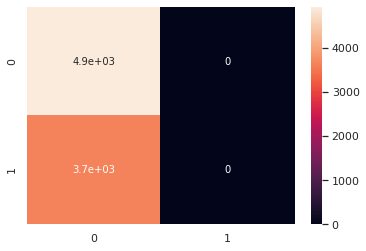

In [60]:


y_pred = model_logit.predict(X_test_binary)
cf_matrix = confusion_matrix(y_test_binary, y_pred)
sns.heatmap(cf_matrix, annot=True)

**Important**

The following cross validation on SVC is also done on test dataset (200 + 150) samples

In [ ]:
# SVC for test dataset

model_svc = svm.SVC()
scores = cross_val_score(model_svc, X_train_binary, y_train_binary, cv=5)
scores

array([0.58490566, 0.56603774, 0.52830189, 0.51923077, 0.55769231])

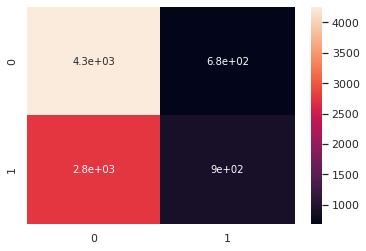

In [62]:
# SVC on full dataset
model_svc = svm.SVC()
model_svc.fit(X_train_binary, y_train_binary)
y_pred_svc = model_svc.predict(X_test_binary)
cf_matrix_svc = confusion_matrix(y_test_binary, y_pred_svc)
sns.heatmap(cf_matrix_svc, annot=True)

In [63]:
model_quality(y_test_binary, y_pred_svc) 

(0.6004890544946437, 0.5546008719301013, 0.34410246606767353)

On full dataset SCV works better than custom Logit model

Gridsearch of custom model parameters even on small dataset is sooo slow

In [ ]:
from sklearn.model_selection import GridSearchCV

betas = np.logspace(-5, -2, 10)
gammas = np.logspace(-5, -2, 10)

gs = GridSearchCV(model_logit, param_grid={'beta' : betas, 'gamma' : gammas})
gs.fit(X_train_binary, y_train_binary)

gs.best_params_

KeyboardInterrupt: ignored

In [66]:
# SVC gridsearch
from sklearn.model_selection import GridSearchCV
cs = np.logspace(-5, -1, 10)
model_svm = svm.SVC()
gs = GridSearchCV(model_svm, param_grid={'C' : cs})
gs.fit(X_train_binary, y_train_binary)

print(gs.best_params_)

{'C': 0.1}


It took 1 hour to count, aaand I forgot to set roc-auc as scoring parameter... 

cv=5 by default

In [68]:
cs = np.logspace(-3, 0, 10)
model_svm = svm.SVC()
gs_roc_auc = GridSearchCV(model_svm, param_grid={'C' : cs}, scoring='roc_auc')
gs_roc_auc.fit(X_train_binary, y_train_binary)

print(gs_roc_auc.best_params_)

{'C': 0.21544346900318823}


#### 9. [1 point] Analysing ROC_AUC

It is possible to control the proportion of statistical errors of different types using different thresholds for choosing a class. Plot ROC curves for Logistic Regression and SVC, show the threshold on ROC curve plots. Choose such a threshold that your models have no more than 30% of false positive errors rate 

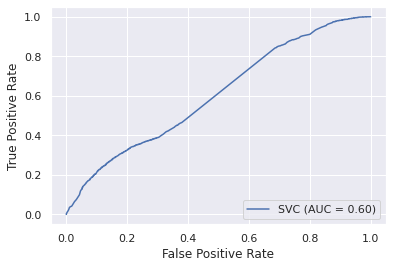

In [54]:
from sklearn.metrics import plot_roc_curve

# model_svc_best_params = gs_roc_auc.best_estimator_
model_svc_best_params = svm.SVC(C=0.21544346900318823)
model_svc_best_params.fit(X_train_binary, y_train_binary)
display_svc = plot_roc_curve(model_svc_best_params, X_test_binary, y_test_binary)

In [84]:
from sklearn.metrics import roc_curve
y_pred = model_svc_best_params.predict(X_test_binary)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)

In [85]:
thresholds

array([ 2,  1, -1])

In [82]:
from sklearn.metrics import roc_curve

y_pred = model_logit.predict(X_test_binary)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred)

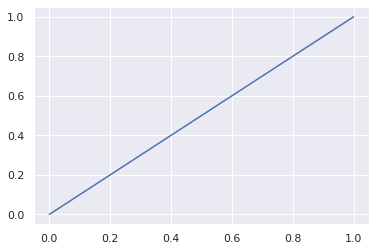

In [83]:
sns.lineplot(x=fpr, y=tpr)

### Multiclass logit

#### 10. [1 point] Take the One-VS-Rest classifier (use sklearn) and apply to Logit model (one you've made in the 4th task) in order to get multiclass linear classifier

<a href="https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html">OneVsRestClassifier</a>

* use the whole dataset with 6 authors
* divide the data into train and test samples with 3/4 split rate
* train the model using cross validation
* plot confusion matrix for train and test samples
* compute all possible and relevant metrics for test sample (use sklearn)
* using GridSearchCV - find the best parameters for the models (by averaged ROC_AUC score)
* make conclusions about the model

In [39]:
# small test dataset with TF-IDF transformation

from sklearn.multiclass import OneVsRestClassifier


X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(X_tfidf_test.todense(), 
                                                                    [author_class.get(author) for author in target_test],
                                                                    random_state=42,
                                                                    train_size=0.75)
y_train_small[:10]

[4, 0, 0, 0, 4, 0, 0, 1, 2, 1]

In [47]:
model_logit_mc = Logit(gamma=0.0001, beta=0.0001, max_iter=500)
classifier = OneVsRestClassifier(model_logit_mc).fit(X_train_small, y_train_small)

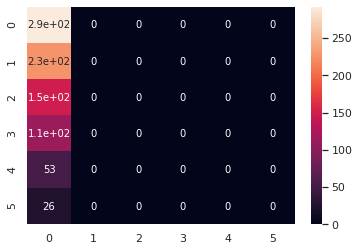

In [48]:
y_pred_train = classifier.predict(X_train_small)
cm_multiclass_train = confusion_matrix(y_train_small, y_pred_train)
sns.heatmap(cm_multiclass_train, annot=True)

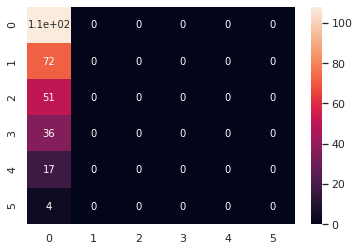

In [49]:
y_pred_test = classifier.predict(X_test_small)
cm_multiclass_test = confusion_matrix(y_test_small, y_pred_test)
sns.heatmap(cm_multiclass_test, annot=True)

Everyone is Достоевский

In [40]:
# X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf
# full dataset, 100 iteration to save time

model_logit_mc_full = Logit(gamma=0.0001, beta=0.0001, max_iter=100)
classifier = OneVsRestClassifier(model_logit_mc_full).fit(X_train_tfidf.todense(), y_train_tfidf)


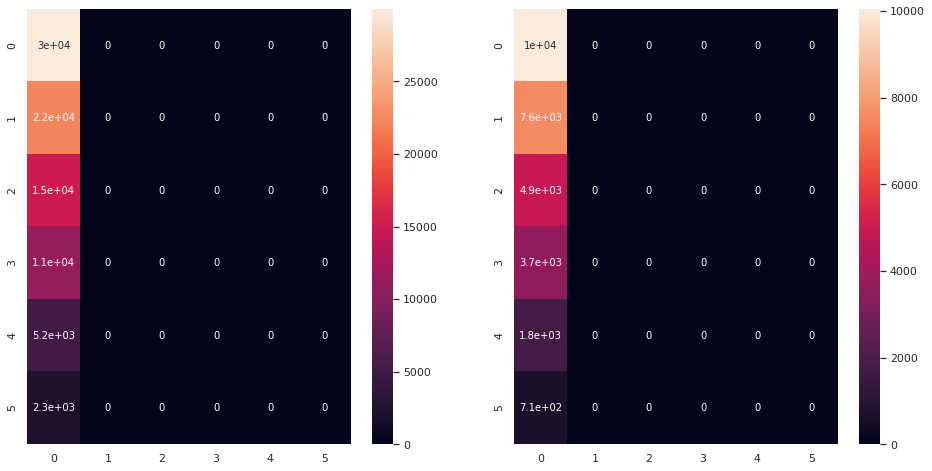

In [46]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
y_pred_train_full = classifier.predict(X_train_tfidf.todense())
cm_multiclass_train_full = confusion_matrix(y_train_tfidf, y_pred_train_full)
sns.heatmap(cm_multiclass_train_full, annot=True, ax=axs[0]) 
 
y_pred_test_full = classifier.predict(X_test_tfidf.todense())
cm_multiclass_test_full = confusion_matrix(y_test_tfidf, y_pred_test_full)
sns.heatmap(cm_multiclass_test_full, annot=True, ax=axs[1])

Everyone is Достоевский again...

In [80]:
# from sklearn.metrics import roc_auc_score
accuracy_score(np.array(y_test_tfidf), y_pred_test_full)

0.3490782608695652

In [67]:
from sklearn.model_selection import GridSearchCV

betas = np.logspace(-5, -2, 4)
gammas = np.logspace(-5, -2, 4)
estimators = []
for beta in betas:
  for gamma in gammas:
    estimators.append(Logit(beta=beta, gamma=gamma))

model_logit_gs = OneVsRestClassifier(Logit())
gs_multiclass = GridSearchCV(model_logit_gs, param_grid={'estimator' : estimators}, scoring='roc_auc_ovr')

gs_multiclass.fit(X_train_small, y_train_small)

print(gs_multiclass.best_params_)

KeyboardInterrupt: ignored

This cell was running 2.5 hours and didn't finish execution because of failed internet connection, sorry
